In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
#ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['movieId','title','genres'], header=0)

ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [4]:
#items

In [5]:
items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
items_dummy.head()

,item,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [7]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [8]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 1, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
    

test _reccomend
test _reccomend


In [9]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs_joined = all_recs.join(items_dummy.set_index('item'), on='item')
all_recs_joined.head()

,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,141,3.5625,1,1,ItemItem,"Birdcage, The (1996)",Comedy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,349,3.5625,1,2,ItemItem,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1968,3.5625,1,3,ItemItem,"Breakfast Club, The (1985)",Comedy|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1961,3.5625,1,4,ItemItem,Rain Man (1988),Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,480,3.5625,1,5,ItemItem,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0,1,1,...,0,0,0,0,0,0,1,1,0,0


In [10]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,1,1343,2.0
1,1,1339,3.5
2,1,1029,3.0
3,1,1263,2.0
4,2,356,3.0


In [11]:
#all_recs_joined['item'].values

In [12]:
_protected_group2 = all_recs_joined.loc[all_recs_joined['Action'] == 1]
_protected_group2.head()
_protected_group2['item'].values

array([  349,   480,  1580,  2716,  5349,   377,  1544,  1580,  1953,
        2716,  5349,  1544,  2193,   349,   480,  1953,   377,  1544,
        2193,   592,  5349,   377,   592,   480,   349,  1953,  1580,
        2716,  2193,  1197,  2959,   589,   349,   480,  2406,  2640,
        2628,  1291,  1396,  2723,  1387,  2005,   541,  1858,  2115,
        3265,  1127,  1036,   260,  1196,  2991,  1208,  1953,  8636,
        2628,  2640,  1291,  1198,  2723,  1196,  1200,  1220,  2115,
        1210,  2406,  1127,  1208,   260,  1858,   541,  1396,  1387,
        1036,  3265,  2991,  2005,  2000,  2616,  1918,  2105,  1544,
        1953,  1377,  2986,   173,  2002,   610,  1374,  2409,  2403,
        2916,   434,   442,   464,   185,  2683,  1196,  1200,  1858,
        1198,  1208,  1036,  2005,  1127,  2000,  1210,  1291,  1220,
        1387,  7153,  3753, 58559,   367,  6502, 33679,  8636, 44191,
        5349,   110,  2028,   589,  1127,  2005,  2000,  2115,  1220,
        1291,  1210,

In [13]:
# user , algorithms = iput to group_cols --> de koloner der skal  groupes på 
rla = topnFair.FairRecListAnalysis(['user', "Algorithm"])
rla.add_metric("rND")
rla.add_metric("rKL")
rla.add_metric("rRD")
results = rla.compute(all_recs_joined, test_data)
results.head()

ti_cols:  ['user', 'item']
res.index:  MultiIndex(levels=[[1, 2, 3, 4, 5], ['ALS', 'ItemItem']],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['user', 'Algorithm'])
                rND  rKL  rRD
user Algorithm               
1    ALS        NaN  NaN  NaN
     ItemItem   NaN  NaN  NaN
2    ALS        NaN  NaN  NaN
     ItemItem   NaN  NaN  NaN
3    ALS        NaN  NaN  NaN
tr_key : (1,)
tr_key:  (1,)
grecs
100
calculateNDFairnes
    item     score  user  rank Algorithm                            title  \
89  2023  3.760453     1     1       ALS  Godfather: Part III, The (1990)   
90   858  3.535793     1     2       ALS            Godfather, The (1972)   
91  1197  3.482773     1     3       ALS       Princess Bride, The (1987)   
92  1221  3.452012     1     4       ALS   Godfather: Part II, The (1974)   
93  6711  3.452012     1     5       ALS       Lost in Translation (2003)   

                                     genres  (no 

calculating normalizer with userN= 20 , proN 7 , measure rRD
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  20
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calc

calculating normalizer with userN= 100 , proN 25 , measure rRD
calculateNDFairnessPara
user_n =  100
pro_n =  25
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
calculateNDFairnessPara
user_n =  100
pro_n =  25
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
calculateNDFairnessPara
user_n =  100
pro_n =  25
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
calculateNDFairnessPara
user_n =  100
pro_n =  25
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
calculateNDFairnessPara
user_n =  100
pro_n =  25
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
calculateNDFairnessPara
user_n =  100
pro_n =  25
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
c

pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  20
pro_n =  6
protectedgroup
[1580 1953 2716 5349 1544 2193]
tr_key : (3,)
tr_key:  (3,)
grecs
100
calculateNDFairnes
     item     score  user  rank Algorithm                        

pro_n =  32
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
calculateNDFairnessPara
user_n =  100
pro_n =  32
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
calculateNDFairnessPara
user_n =  100
pro_n =  32
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
calculateNDFairnessPara
user_n =  100
pro_n =  32
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
calculateNDFairnessPara
user_n =  100
pro_n =  32
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
calculateNDFairnessPara
user_n =  100
pro_n =  32
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15

user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[0, 1, 2, 3, 4, 5]
calculateNDFairnessPara
user_n =  22
pro_n =  6
protectedgroup
[ 349  480 1953  377 1544 2193]
tr_key : (4,)
tr_key:  (4,)
grecs
100
calculateNDFairnes
     item     score  user  rank Algorithm  \
389  2023  4.386370     4     1       ALS   
390   595  4.386290     4     2       ALS   
391  7153  4.370022     4     3       ALS   
392   355  4.370022     4     4     

tr_key:  (4,)
grecs
14
calculateNDFairnes
    item     score  user  rank Algorithm                title  \
62   356  5.200000     4     1  ItemItem  Forrest Gump (1994)   
63  1721  4.950000     4     2  ItemItem       Titanic (1997)   
64   296  4.916667     4     3  ItemItem  Pulp Fiction (1994)   
65   150  4.916667     4     4  ItemItem     Apollo 13 (1995)   
66    39  4.916667     4     5  ItemItem      Clueless (1995)   

                         genres  (no genres listed)  Action  Adventure  \
62     Comedy|Drama|Romance|War                   0       0          0   
63                Drama|Romance                   0       0          0   
64  Comedy|Crime|Drama|Thriller                   0       0          0   
65         Adventure|Drama|IMAX                   0       0          1   
66               Comedy|Romance                   0       0          0   

     ...     Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  \
62   ...             0       0     0        0  

calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 

pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n =  100
pro_n =  28
protectedgroup
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
calculateNDFairnessPara
user_n

user_n =  13
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  13
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  13
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  13
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  13
pro_n =  7
protectedgroup
[0, 1, 2, 3, 4, 5, 6]
calculateNDFairnessPara
user_n =  13
pro_n =  7
protectedgroup
[ 592  480  349 1953 1580 2716 2193]


rND       rKL       rRD
user Algorithm                              
1    ALS        0.085719  0.023062  0.085661
     ItemItem   0.142857  0.012720  0.000000
2    ALS        0.101883  0.021534  0.208795
     ItemItem   0.000000  0.000000  0.000000
3    ALS        0.105035  0.039500  0.023453

In [14]:
results.groupby('Algorithm').rND.mean()

Algorithm
ALS         0.110802
ItemItem    0.170068
Name: rND, dtype: float64

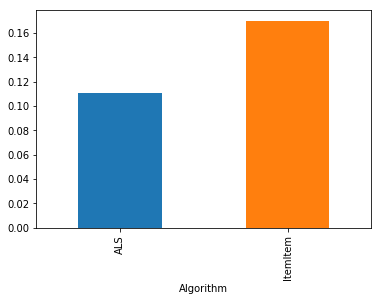

In [15]:
results.groupby('Algorithm').rND.mean().plot.bar()